# Section 2: CIFAR-10 Image Classification with Transfer Learning
# Augmentation

## Loading Model

Transfer learning will be used with Google's vit-base-patch16-224 which can be found here: https://huggingface.co/google/vit-base-patch16-224?library=transformers. The model uses 224x224 images but has its own processor to deal with resizing and other transformations. The result of that processing is a dictionary that includes a 3x224x224 tensor.

In [1]:
from transformers import TFViTModel

# Load model (without output layer)
print('Loading from Hugging Face ...')
base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224')
base_model.save_pretrained('augment_vit_model')

/apps/tensorflow/2.18/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-16 13:09:00.700510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744823340.718687 3104857 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744823340.724360 3104857 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744823340.737807 3104857 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

Loading from Hugging Face ...


2025-04-16 13:09:06.746340: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task

In [2]:
# Show layers
print('Original Layers')
print('------------------')

for layer in base_model.layers:
    print(layer)

Original Layers
------------------


## Loading Data

The data will be loaded (processing will be done later with training).

In [3]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Initial Training

The main layers will be frozen, but the output layer will be replaced to allow for 10 classes. It is very minimalistic so that there can be a baseline. Moving forward, about 2/50 or 4/50 of the training dataset will be used since it will allow more options to be explored to possibly improve the previously trained baseline model.

In [4]:
from tensorflow.keras.layers import Input, Dense, Layer, Permute, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from transformers import TFViTModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras
import time

# Wrapper to convert to Keras layer
class ViTLayer(Layer):
    def __init__(self, vit_model=None, model_name='google/vit-base-patch16-224', **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        # Load vit_model
        self.vit_model = vit_model if vit_model is not None else TFViTModel.from_pretrained('augment_vit_model')
        # Store model name for serialization (needed for saving/loading)
        self.model_name = model_name
    
    def call(self, inputs):
        outputs = self.vit_model(inputs)
        return outputs.pooler_output
    
    def get_config(self):
        config = super(ViTLayer, self).get_config()
        config.update({
            'model_name': self.model_name
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        # Get model_name and remove it from config to avoid passing to init
        model_name = config.pop('model_name')
        # Create instance without vit_model (will be loaded in init)
        return cls(model_name=model_name, **config)

# Form new model
model = Sequential([
    Input(shape=(3, 224, 224)),
    Permute((2, 3, 1)),
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1),
    Permute((3, 1, 2)),
    ViTLayer(base_model, model_name='google/vit-base-patch16-224', name='base_transformer'),
    Dense(10, activation='softmax', name='classifier')
])

# Show layers
print(f'Layers: {model.layers}')

# Freeze everything except output layer
model.get_layer(name='base_transformer').trainable = False

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())

Layers: [<Permute name=permute, built=True>, <RandomFlip name=random_flip, built=True>, <RandomRotation name=random_rotation, built=True>, <RandomZoom name=random_zoom, built=True>, <Permute name=permute_1, built=True>, <ViTLayer name=base_transformer, built=True>, <Dense name=classifier, built=True>]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute (Permute)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 3, 224, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_transformer (ViTLayer)     │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 10)             │         7,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None


Start training (using K-Fold Cross Validation) ...

In [5]:
from transformers import AutoImageProcessor

# Tracking metrics
start_time = time.time()
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

# Process in batches and each batch with KFold cross validation
num_batches = 50
num_kfolds = 4
batch_kf = StratifiedKFold(n_splits=num_batches, shuffle=True, random_state=42)
val_kf = StratifiedKFold(n_splits=num_kfolds, shuffle=True, random_state=42)
batch_num = 1
total_batches_to_train = 2

for _, batch_index in batch_kf.split(X_train, y_train):
    
    print('-------------------------------------')
    print(f'Working on Batch {batch_num} ...')
    print('-------------------------------------')
    X_train_batch = X_train[batch_index]
    y_train_batch = y_train[batch_index]
    fold_num = 1
    
    for train_index, val_index in val_kf.split(X_train_batch, y_train_batch):
        
        print(f'Working on Fold {fold_num} ...')
        X_train_split = X_train_batch[train_index]
        y_train_split = y_train_batch[train_index]
        X_val_split = X_train_batch[val_index]
        y_val_split = y_train_batch[val_index]
        
        processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
        X_train_split = processor(images=X_train_split, return_tensors='tf')['pixel_values']
        X_val_split = processor(images=X_val_split, return_tensors='tf')['pixel_values']
        
        history = model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=1)
        train_accuracy += history.history['accuracy']
        val_accuracy += history.history['val_accuracy']
        train_loss += history.history['loss']
        val_loss += history.history['val_loss']
        fold_num += 1
        
    # Train on half of the training set
    if batch_num == total_batches_to_train:
        break
        
    batch_num += 1
    
# Print time it took to train
end_time = time.time()
train_time_secs = end_time - start_time
train_time_mins = train_time_secs / 60
print(f'Training Time: {train_time_mins} mins')

-------------------------------------
Working on Batch 1 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.2428 - loss: 2.2078 - val_accuracy: 0.5960 - val_loss: 1.5364
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.5619 - loss: 1.5164 - val_accuracy: 0.8280 - val_loss: 0.9247
Working on Fold 3 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6900 - loss: 1.1224 - val_accuracy: 0.9040 - val_loss: 0.7008
Working on Fold 4 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.7035 - loss: 1.0048 - val_accuracy: 0.9480 - val_loss: 0.4541
-------------------------------------
Working on Batch 2 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.7085 - loss: 0.9272 - val_accuracy: 0.9280 - val_loss: 0.4167
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.7461 - loss: 0.8385 - val_accuracy: 

In [6]:
from tensorflow.keras.models import load_model

# Save model
model.save('augment_transfer_model.keras')

Some preliminary metrics will be shown ...

Best Training Accuracy: 0.765333354473114
Best Validation Accuracy: 0.9879999756813049
Average Training Accuracy: 0.6644999980926514
Average Validation Accuracy: 0.8854999989271164
Last Training Accuracy: 0.7586666941642761
Last Validation Accuracy: 0.9879999756813049


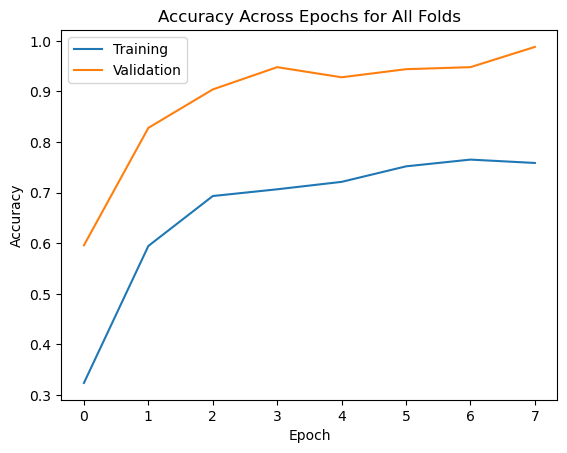

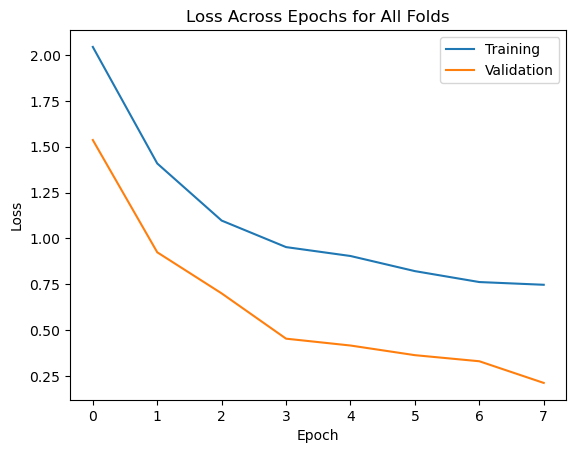

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Print accuracies across all epochs and folds
print(f'Best Training Accuracy: {max(train_accuracy)}')
print(f'Best Validation Accuracy: {max(val_accuracy)}')
print(f'Average Training Accuracy: {np.mean(train_accuracy)}')
print(f'Average Validation Accuracy: {np.mean(val_accuracy)}')
print(f'Last Training Accuracy: {train_accuracy[-1]}')
print(f'Last Validation Accuracy: {val_accuracy[-1]}')

# Plot accuracy
num_total_epochs = len(train_accuracy)
plt.plot(range(num_total_epochs), train_accuracy, label='Training')
plt.plot(range(num_total_epochs), val_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Across Epochs for All Folds')
plt.legend()
plt.show()

# Plot loss
num_total_epochs = len(train_loss)
plt.plot(range(num_total_epochs), train_loss, label='Training')
plt.plot(range(num_total_epochs), val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Across Epochs for All Folds')
plt.legend()
plt.show()

Since images were augmented randomly, performance will be shown on the original images without transformations. This will give a more direct comparison to the baseline model.

Training Performance for Batch 1
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step
Time to Predict: 111.83010053634644 secs

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       100
           1       0.97      0.99      0.98       100
           2       0.98      0.93      0.95       100
           3       0.93      0.89      0.91       100
           4       0.95      0.99      0.97       100
           5       0.92      0.92      0.92       100
           6       0.97      0.98      0.98       100
           7       0.95      0.96      0.96       100
           8       0.94      0.98      0.96       100
           9       1.00      0.96      0.98       100

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


Confusion Matrix


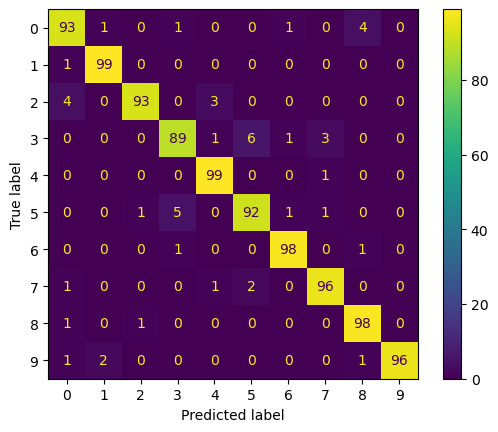


Training Performance for Batch 2
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step
Time to Predict: 110.46808576583862 secs

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       100
           1       0.97      0.95      0.96       100
           2       0.99      1.00      1.00       100
           3       0.98      0.88      0.93       100
           4       0.97      0.95      0.96       100
           5       0.86      0.96      0.91       100
           6       0.96      0.99      0.98       100
           7       0.96      0.95      0.95       100
           8       0.96      0.98      0.97       100
           9       0.97      0.98      0.98       100

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


Confusion Matrix


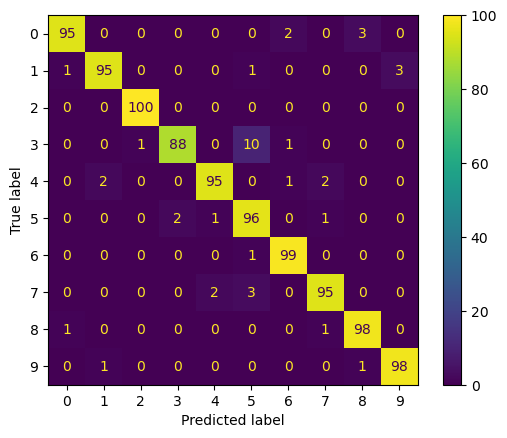

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold, train_test_split

# Function to evaluate performance
def evaluate(model, X_true, y_true):

    """ Evaluate Model Performance """

    # List class names in order
    class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"]

    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_true)
    y_pred = np.argmax(y_pred, axis=-1)
    end_time = time.time()
    pred_time_secs = end_time - start_time
    print(f'Time to Predict: {pred_time_secs} secs')
    print()

    # Precision, Recall, F1-score
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# Show performance on first batch and last batch
batch_kf = StratifiedKFold(n_splits=num_batches, shuffle=True, random_state=42)
batch_num = 1

for _, batch_index in batch_kf.split(X_train, y_train):
    
    if batch_num == 1 or batch_num == total_batches_to_train:
        print(f'Training Performance for Batch {batch_num}')
        print('----------------------------------------------')
        X_train_batch = X_train[batch_index]
        y_train_batch = y_train[batch_index]
        processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
        X_train_batch = processor(images=X_train_batch, return_tensors='tf')['pixel_values']
        evaluate(model, X_train_batch, y_train_batch)
        print()
        
    batch_num += 1

# Regularization

Experimentation will be repetitive so the code I've been using has been put into a general_training.py file for reuse. We will try a regularization dense layer and dropout after.

/apps/tensorflow/2.18/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-16 16:25:47.172563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744835147.193597  679796 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744835147.200148  679796 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744835147.216412  679796 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

Loading from Hugging Face ...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Layers
------------------
Using header and footer layers ...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_transformer (ViTLayer)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
-------------------------------------
Working on Batch 1 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.3747 - loss: 2.0109 - val_accuracy: 0.9120 - val_loss: 0.7763
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8754 - loss: 0.6882 - val_accuracy: 0.9440 - val_loss: 0.3793
Working on Fold 3 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9284 - loss: 0.4216 - val_accuracy: 0.9600 - val_loss: 0.2798
Working on Fold 4 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9641 - loss: 0.3183 - val_accuracy: 0.9840 - val_loss: 0.2234
-------------------------------------
Working on Batch 2 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9378 - loss: 0.3617 - val_accuracy: 0.9520 - val_loss: 0.2895
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9544 - loss: 0.2984 - val_accuracy: 

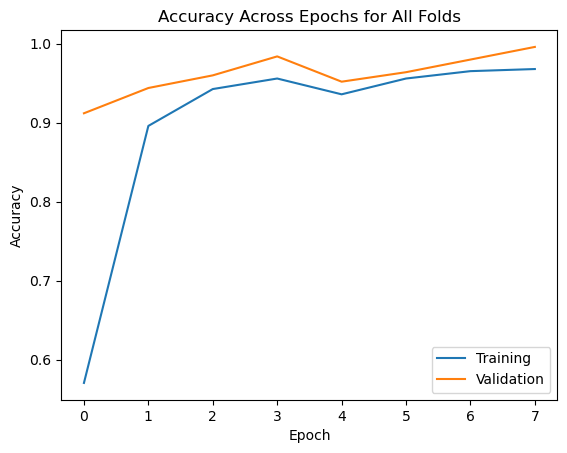

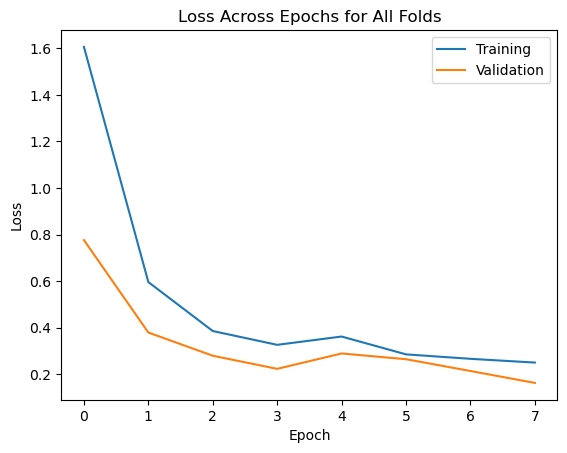

Training Performance for Batch 1
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step
Time to Predict: 100.08172369003296 secs

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.97      1.00      0.99       100
           2       0.99      0.96      0.97       100
           3       0.97      0.95      0.96       100
           4       0.98      1.00      0.99       100
           5       0.96      0.99      0.98       100
           6       1.00      0.98      0.99       100
           7       1.00      1.00      1.00       100
           8       0.97      0.98      0.98       100
           9       0.99      0.97      0.98       100

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Confusion Matrix


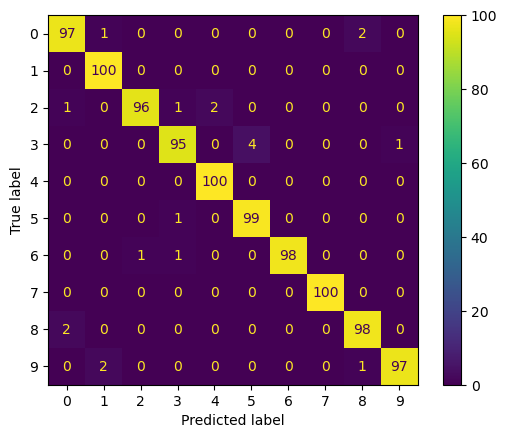


Training Performance for Batch 2
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step
Time to Predict: 94.57675385475159 secs

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.99      0.98      0.98       100
           2       1.00      1.00      1.00       100
           3       0.98      0.96      0.97       100
           4       1.00      1.00      1.00       100
           5       0.96      0.98      0.97       100
           6       0.98      0.99      0.99       100
           7       1.00      1.00      1.00       100
           8       0.99      0.99      0.99       100
           9       0.97      0.99      0.98       100

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


Confusion Matrix


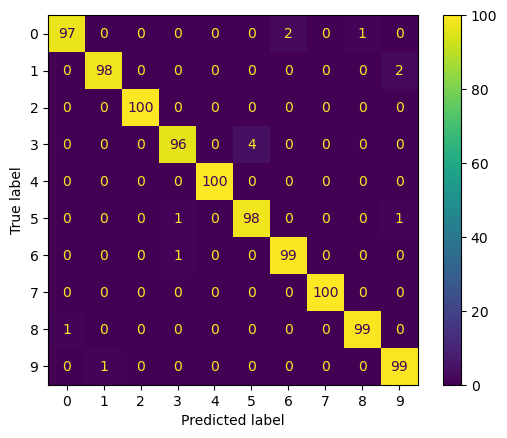

In [1]:
from general_training import train_model
from tensorflow.keras.layers import Input, Dense, Layer, Permute, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras.models import Sequential
from transformers import TFViTModel
from tensorflow.keras.regularizers import l2

trial_name ='regularize'

# Train model
header_layers = Sequential([
    Input(shape=(3, 224, 224)),
])

footer_layers = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
    Dropout(0.3)
])

train_model(trial_name, header_layers=header_layers, footer_layers=footer_layers)

Now we will try regularization with data augmentation.

Loading from Hugging Face ...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Layers
------------------
Using header and footer layers ...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 3, 224, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_transformer (ViTLayer)     │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,866 (194.79 KB)

 Trainable params: 49,866 (194.79 KB)

 Non-trainable params: 0 (0.00 B)

None
-------------------------------------
Working on Batch 1 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.2153 - loss: 2.3531 - val_accuracy: 0.7680 - val_loss: 1.4212
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.5747 - loss: 1.5326 - val_accuracy: 0.9160 - val_loss: 0.7408
Working on Fold 3 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.6929 - loss: 1.0744 - val_accuracy: 0.9280 - val_loss: 0.5158
Working on Fold 4 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.7094 - loss: 0.9907 - val_accuracy: 0.9400 - val_loss: 0.3738
-------------------------------------
Working on Batch 2 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6980 - loss: 0.9965 - val_accuracy: 0.9360 - val_loss: 0.4121
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.7612 - loss: 0.8921 - val_accuracy: 

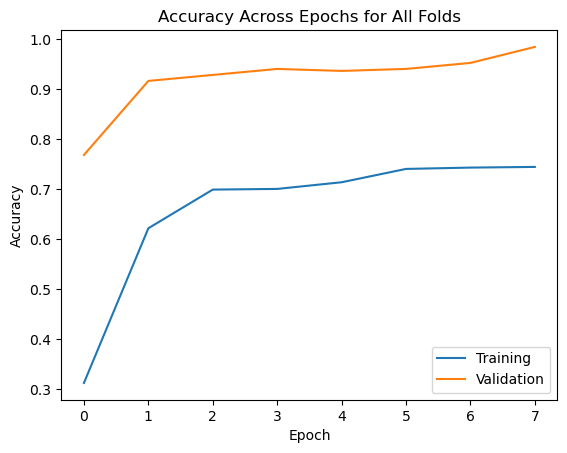

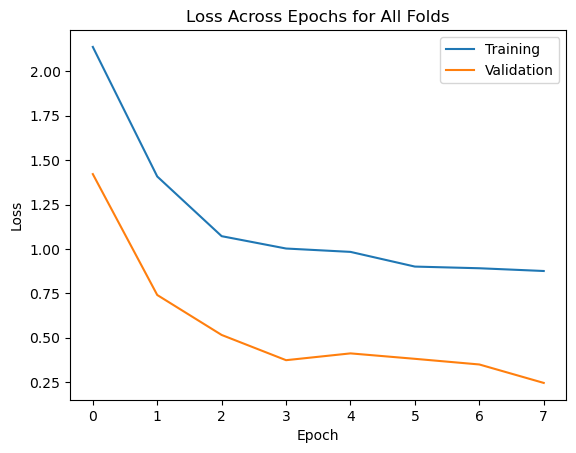

Training Performance for Batch 1
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step
Time to Predict: 99.81954193115234 secs

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       100
           1       0.96      1.00      0.98       100
           2       0.98      0.94      0.96       100
           3       0.96      0.90      0.93       100
           4       0.95      0.99      0.97       100
           5       0.90      0.97      0.93       100
           6       0.97      0.98      0.98       100
           7       0.98      0.95      0.96       100
           8       0.94      0.96      0.95       100
           9       0.99      0.94      0.96       100

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000


Confusion Matrix


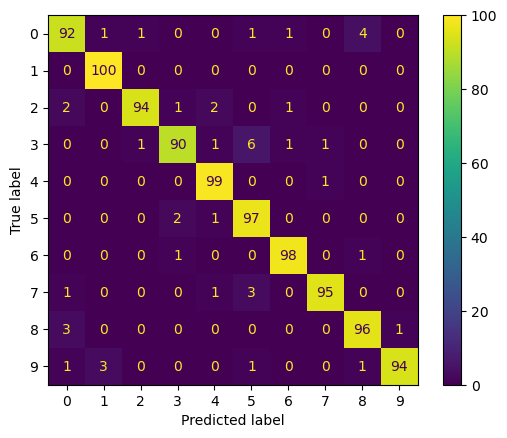


Training Performance for Batch 2
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step
Time to Predict: 94.25846982002258 secs

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       100
           1       0.98      0.94      0.96       100
           2       1.00      1.00      1.00       100
           3       0.92      0.91      0.91       100
           4       0.99      0.98      0.98       100
           5       0.90      0.96      0.93       100
           6       0.98      0.98      0.98       100
           7       0.99      0.97      0.98       100
           8       0.97      0.99      0.98       100
           9       0.95      0.96      0.96       100

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.97      1000
weighted avg       0.97      0.96      0.97      1000


Confusion Matrix


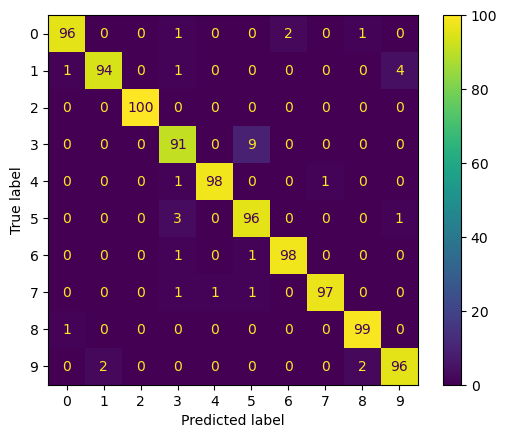

In [2]:
from general_training import train_model
from tensorflow.keras.layers import Input, Dense, Layer, Permute, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras.models import Sequential
from transformers import TFViTModel
from tensorflow.keras.regularizers import l2

trial_name ='regularize_and_augment'

# Train model
header_layers = Sequential([
    Input(shape=(3, 224, 224)),
    Permute((2, 3, 1)),
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1),
    Permute((3, 1, 2))
])

footer_layers = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
    Dropout(0.3)
])

train_model(trial_name, header_layers=header_layers, footer_layers=footer_layers)

 A personal learning rate schedule was implemented in general_training.py similar to the logic of ReduceLROnPlateau, monitoring validation loss. A patience of 0 with exponentially reduced learning rates and a low initial learning rate is used to see if we can prevent overshooting the optimal loss and get a more fine-tuned model.

/apps/tensorflow/2.18/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-20 16:03:11.288820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745179391.309357 3821908 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745179391.315706 3821908 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745179391.331258 3821908 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vi_t_layer (ViTLayer)           │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 10)             │         7,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,072 (90.13 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,382 (60.09 KB)

None
-------------------------------------
Working on Batch 1 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.9645 - loss: 0.1074 - val_accuracy: 0.9640 - val_loss: 0.0856
LEARNING RATE PATIENCE EXCEEDED: adjusting rate to 5e-05
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.9660 - loss: 0.0954 - val_accuracy: 0.9680 - val_loss: 0.1123
LEARNING RATE PATIENCE EXCEEDED: adjusting rate to 2.5e-05
Working on Fold 3 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.9662 - loss: 0.1086 - val_accuracy: 0.9560 - val_loss: 0.1078
LEARNING RATE PATIENCE EXCEEDED: adjusting rate to 1.25e-05
Working on Fold 4 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.9548 - loss: 0.1179 - val_accuracy: 0.9760 - val_loss: 0.1046
LEARNING RATE PATIENCE EXCEEDED: adjusting rate to 6.25e-06
-------------------------------------
Working on Batch 2 ...
-------------------------------------
Working o

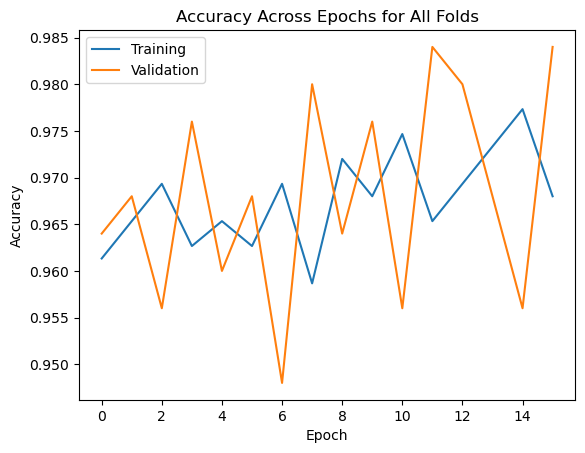

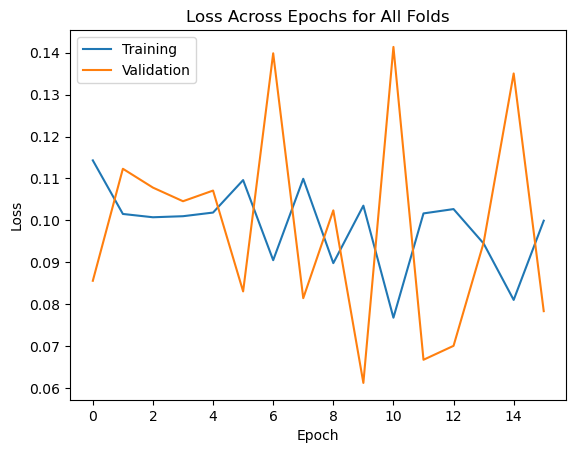

Training Performance for Batch 1
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step
Time to Predict: 140.27123594284058 secs

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       0.98      1.00      0.99       100
           2       0.97      0.93      0.95       100
           3       0.92      0.92      0.92       100
           4       0.94      1.00      0.97       100
           5       0.97      0.94      0.95       100
           6       0.97      0.97      0.97       100
           7       1.00      1.00      1.00       100
           8       0.96      0.97      0.97       100
           9       0.98      0.97      0.97       100

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


Confusion Matrix


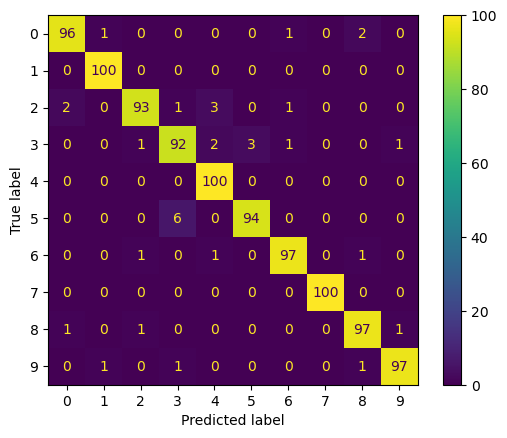


Training Performance for Batch 4
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step
Time to Predict: 135.58464670181274 secs

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       100
           1       0.97      0.97      0.97       100
           2       0.99      0.96      0.97       100
           3       0.90      0.96      0.93       100
           4       0.93      0.97      0.95       100
           5       0.96      0.95      0.95       100
           6       0.97      0.95      0.96       100
           7       1.00      0.97      0.98       100
           8       0.95      0.98      0.97       100
           9       0.98      0.97      0.97       100

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


Confusion Matrix


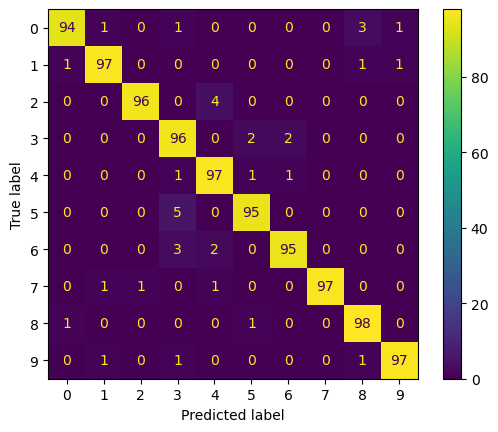

In [ ]:
from general_training import train_model, train_model_lr, keep_training_lr
from tensorflow.keras.layers import Input, Dense, Layer, Permute, RandomFlip, RandomRotation, RandomZoom, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Flatten
from tensorflow.keras.models import Sequential
from transformers import TFViTModel
from tensorflow.keras.regularizers import l2

new_trial_name ='baseline_lr'
old_trial_name = 'baseline'

# Continue training
model = keep_training_lr(new_trial_name=new_trial_name, old_trial_name=old_trial_name, lr_patience=0, total_batches_to_train=4, lr_initial=1e-4, lr_min=1e-7, lr_factor=0.5)